# Pre-Processing Dataset

Here I generate the `gal_fname1` which cointains the columns needed to this study: `Mr, R, R/R200, v_los, v_circ, orbital, infall, interloper`.


In [1]:
import sys
sys.path.append('/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/')

from file_loc import FileLocs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table, vstack
import astropy.io.ascii as at
from astropy import units as u

# Reading Initial Data

In [3]:
fl = FileLocs(dataset='tng')
hdf_file = fl.hdf_fname_z0

In [4]:
def load_files(fname,key='Halos'):
    pi = pd.read_hdf(hdf_file, key = key)
    pi = Table.from_pandas(pi)
    return pi

In [63]:
infiles = ['../data/TNG300-1_GalEvol_z0p00.hdf5']

In [64]:
print('--------Initial Files-------')

t1,t2 = [], []
for hdf_file in infiles:
    print('TNG File : %s'%hdf_file)
    t1.append(load_files(hdf_file,key='Halos'))
    t2.append(load_files(hdf_file,key='Subhalos'))

--------Initial Files-------
TNG File : ../data/TNG300-1_GalEvol_z0p00.hdf5


In [65]:
cat = vstack(t1).to_pandas()
gal = vstack(t2).to_pandas()


In [66]:
t1

[<Table length=280>
 HaloID   M200c     R200c   
 int64   float32   float32  
 ------ --------- ----------
      0 15.186333  2432.7222
      1 15.116388  2305.6597
      2 15.014233  2131.6853
      3 14.954083  2035.5553
      4  14.92522  1990.9474
      5 14.865417  1901.6171
      6 14.662083  1626.8896
      7 14.764341  1759.7019
      8 14.600158  1551.3162
      9 14.807001   1818.212
    ...       ...        ...
    314  14.06588  1029.4946
    317 14.035317 1005.62384
    320 14.030957 1002.22217
    334 14.017508   991.9341
    336 14.004802  982.35547
    340 14.060691  1025.3676
    343 14.022865   996.0294
    348 14.019843   993.7146
    370 14.025233   997.8192
    403 14.007652  984.46246]

In [67]:
gal.describe()

,SubhaloID,Mstar,HostHaloID,R_proj,v_los,V200c_host,t_infall,Mstar_bulge,S_over_T,SFR,Stellar_age
count,7.646800e+04,76468.000000,76468.000000,76468.000000,76468.000000,76468.000000,11634.000000,5.711700e+04,56856.000000,57117.000000,57117.000000
mean,1.094334e+06,9.822301,110.809123,1.539164,-32.372556,908.402966,3.948985,-inf,0.689909,0.276386,7.753017
std,9.141358e+05,0.598441,92.132375,0.907592,4136.024708,225.482617,2.912072,NaN,0.131608,0.960426,2.071161
min,0.000000e+00,9.000002,0.000000,0.000000,-11453.596903,663.701728,0.000156,-inf,0.181338,0.000000,0.094187
25%,2.315742e+05,9.319723,30.000000,0.707471,-872.195039,736.335100,1.441333,9.151446e+00,0.605048,0.000000,6.242932
50%,8.591335e+05,9.719595,88.000000,1.587348,-1.467556,832.625512,3.420650,9.524025e+00,0.716621,0.000000,7.801496
75%,2.032249e+06,10.247871,176.000000,2.356246,849.543908,1029.312722,5.937812,9.987023e+00,0.791440,0.171776,9.371714
max,6.044891e+06,12.894207,403.000000,2.999981,11527.601473,1647.993000,12.314668,1.259621e+01,1.082880,40.274799,12.569763


array([[<AxesSubplot:title={'center':'HaloID'}>,
        <AxesSubplot:title={'center':'M200c'}>],
       [<AxesSubplot:title={'center':'R200c'}>, <AxesSubplot:>]],
      dtype=object)

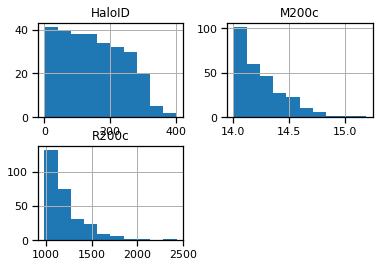

In [68]:
cat.hist()

In [69]:
len(cat)

280

# Mask Data

In [70]:
mask = gal['SubhaloID']>0.
Nsize = np.count_nonzero(mask)

print('Masking Galaxies with no redshift or mass estimations')
print('New Size: %i'%(Nsize))
print('fraction: %.2f'%(1.*Nsize/len(gal)))

Masking Galaxies with no redshift or mass estimations
New Size: 76466
fraction: 1.00


In [71]:
def get_percentile_curve(x,y,alpha=5,Npoints=15):
    xbins  = np.percentile(x,np.linspace(0,100,Npoints))
    indices= [(x>=xl)&(x<xh) for xl, xh in zip(xbins[:-1],xbins[1:])]
    ycurve = np.array([np.percentile(y[idx],alpha) for idx in indices])
    return ycurve, 0.5*(xbins[1:]+xbins[:-1])

In [72]:
# mass        = np.array(gal['Mstar'])
# zgal        = np.array(gal['z'])
# zmask       = (zgal>=0.025)&(zgal<=0.105)
# ylow, zbins = get_percentile_curve(zgal[zmask],mass[zmask],Npoints=16)

# Computing new variables
---------------------------------------


In [73]:
import esutil

gcid = np.array(gal['HostHaloID'])
cid  = np.array(cat['HaloID'])

key = esutil.numpy_util.match(cid,gcid)

In [74]:
gal['M200']    = np.zeros(len(gal))
gal['M200'][key[1]] = cat['M200c'][key[0]]/1000.

gal['R200']    = 99.*np.ones(len(gal))
gal['R200'].iloc[key[1]] = cat['R200c'].iloc[key[0]]/1000.

gal['Rn'] = gal['R_proj']/gal['R200']

<ipython-input-74-d06b87902dd1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal['M200'][key[1]] = cat['M200c'][key[0]]/1000.
/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Distance From The Center
---------------------------------------

To have the phase space we need first to compute the distance from the center, $R/R_{200}$.

<AxesSubplot:>

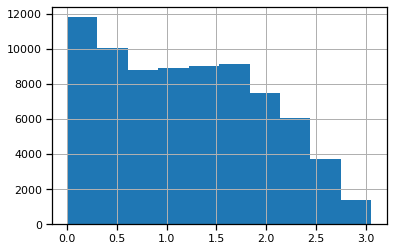

In [75]:
gal['Rn'].hist()

The line of sight velocity
---------------------------------------


Here we compute the line of sight velocity assuming the redshift given by the Yang catalog. For the orbital classification we also need to compute the cluster circular velocity.

In [76]:
def get_los_velocity(z_gal,z_BCG):
    return c_kms*(z_gal - z_BCG)/(1 + z_BCG)

In [77]:
vlos = gal['v_los']

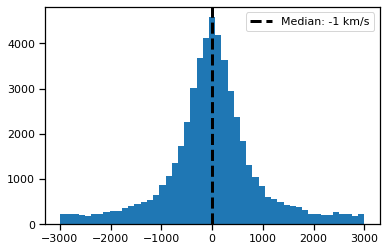

In [78]:
vmask = np.abs(vlos)<=2500.
zm = np.median(vlos[vmask])
_ = plt.hist(vlos,bins=np.linspace(-3000.,3000.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %i km/s'%zm)
plt.legend()

In [79]:
def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun/cosmo.h)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

In [80]:
vc   = gal['V200c_host']

Text(0.5, 0, '$v_{los}/v_{circ}$')

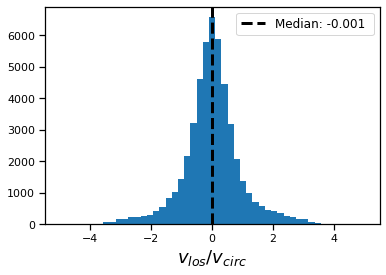

In [81]:
zm = np.median(vlos[vmask]/vc[vmask])

_ = plt.hist(vlos[vmask]/vc[vmask],bins=np.linspace(-5.,5.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %.3f '%zm)
plt.legend(fontsize=12)
plt.xlabel(r'$v_{los}/v_{circ}$',fontsize=18)

In [82]:
gal['vlosn']= vlos/vc

In [83]:
vlosn = vlos/vc
rnorm = gal['Rn']

cut = np.abs(vlosn)<3.0

In [84]:
## change the r200c to the r200m. 

In [85]:
rcls = np.array(gal['R_proj'])*u.Mpc
rcls = rcls.to(u.km).value

In [86]:
year   = 365*24*3600
to_gyr = year*1e9

In [87]:
tinfall = (rcls/(np.abs(vlos)+1e-9))*u.s.to(u.yr)
# tinfall/= to_gyr

In [88]:
gal['t_cross'] = tinfall

/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([  55.,  133.,  318.,  643., 1186., 1987., 3144., 5232., 8061.,
        7780., 6755., 5409., 3463., 2156., 1255.,  692.,  409.,  227.,
         144.,   74.]),
 array([ 7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
         9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
        11.5 , 11.75, 12.  ]),
 <BarContainer object of 20 artists>)

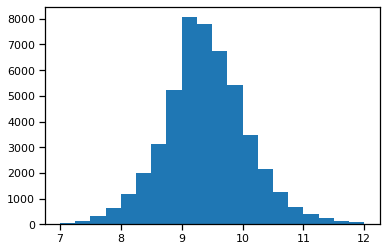

In [89]:
plt.hist(np.log10(tinfall[vmask]),bins=np.linspace(7.,12.,21))

# Orbital Classification
---------------------------------------


Here we assign the classes, orbital, infall and interloper.

In [90]:
from sklearn.ensemble import RandomForestClassifier
import joblib
loaded_rf = joblib.load("/Users/jesteves/Downloads/phase_space/classification_2d_rf.joblib")

/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [91]:
import pandas as pd
df   = pd.DataFrame ({ 'r2d':rnorm, 'vlos':vlosn})
tags = loaded_rf.predict(df) 


In [92]:
tag_probability = loaded_rf.predict_proba(df) 

In [93]:
tag_probability

array([[0.77, 0.23, 0.  ],
       [0.46, 0.38, 0.16],
       [0.85, 0.15, 0.  ],
       ...,
       [0.  , 0.  , 1.  ],
       [0.  , 0.24, 0.76],
       [0.13, 0.78, 0.09]])

In [94]:
def get_random_assignment(prob):
    is_class = np.full(len(prob),0)
    for i,pi in enumerate(prob):
        is_class[i] = int(pi>np.random.random())
    return is_class

In [95]:
porbital= tag_probability[:,0]
pinfall = tag_probability[:,1]
pinterl = tag_probability[:,2]

orbital = get_random_assignment(porbital)
infall  = get_random_assignment(pinfall)
interl  = get_random_assignment(pinterl)

Text(0.5, 0, 'Probability')

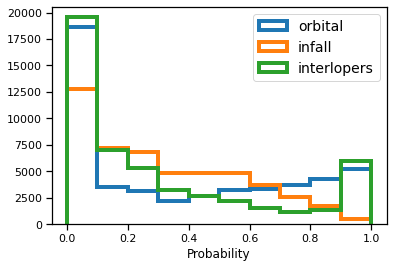

In [96]:
plt.hist(porbital[cut],histtype='step',lw=4,label='orbital')
plt.hist(pinfall[cut],histtype='step',lw=4,label='infall')
plt.hist(pinterl[cut],histtype='step',lw=4,label='interlopers')
plt.legend(fontsize=14)
plt.xlabel('Probability')

In [97]:
# np.count_nonzero(orbital)/len(orbital)
# np.count_nonzero(infall)/len(orbital)
np.count_nonzero(interl)/len(orbital)

0.5428152952869174

In [98]:
gal['infall']     = infall 
gal['orbital']    = orbital
gal['interloper'] = interl

gal['pinfall']     = pinfall 
gal['porbital']    = porbital
gal['pinterloper'] = pinterl

In [99]:
import seaborn as sns
sns.set_context('notebook')

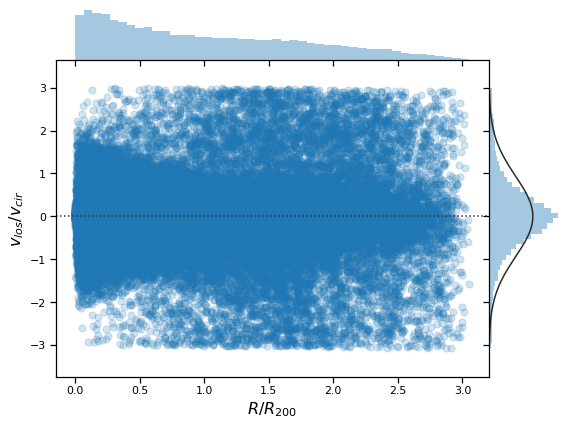

In [100]:
ax = sns.jointplot(x=rnorm[cut], y=vlosn[cut], kind="resid", space=0, height=6, ratio=6, joint_kws = {'scatter_kws':dict(alpha=0.2,s=50)})
ax.set_axis_labels(r'$R/R_{200}$', r'$v_{los}/v_{cir}$ ', fontsize=16)
ax.fig.set_figwidth(8)

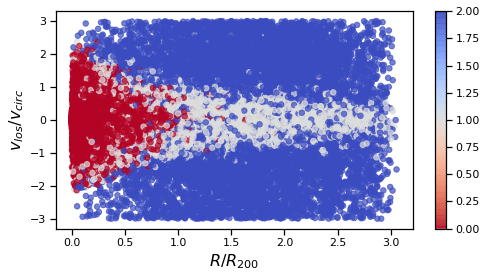

In [101]:
plt.figure(figsize=(8,4))
plt.scatter(rnorm[cut],vlosn[cut],c=tags[cut],alpha=0.7,s=30,cmap='coolwarm_r')
plt.xlabel(r'$R/R_{200}$',fontsize=16)
plt.ylabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.colorbar()

Text(0.5, 0, '$R/R_{200}$')

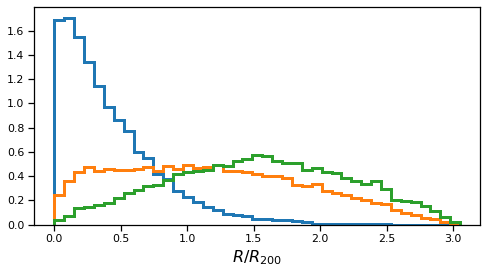

In [102]:
plt.figure(figsize=(8,4))
a = plt.hist(rnorm[cut],weights=orbital[cut],bins=41,density=True,histtype='step',lw=3)
_ = plt.hist(rnorm[cut],weights=infall[cut],bins=a[1],density=True,histtype='step',lw=3)
_ = plt.hist(rnorm[cut],weights=interl[cut],bins=a[1],density=True,histtype='step',lw=3)

plt.xlabel(r'$R/R_{200}$',fontsize=16)


Text(0.5, 0, '$R/R_{200}$')

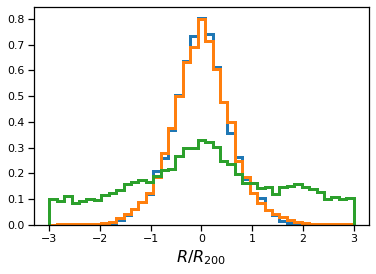

In [103]:
plt.figure(figsize=(6,4))
a = plt.hist(vlosn[cut],weights=orbital[cut],bins=41,density=True,histtype='step',lw=3)
_ = plt.hist(vlosn[cut],weights=infall[cut],bins=a[1],density=True,histtype='step',lw=3)
_ = plt.hist(vlosn[cut],weights=interl[cut],bins=a[1],density=True,histtype='step',lw=3)

plt.xlabel(r'$R/R_{200}$',fontsize=16)


# Star Forming Galaxies Classification
--------------

In first approach we assume a fixed threshold on ssfr. Next step would be to model with a linear fit.

In [104]:
nzero = gal['SFR']>=1e-10
gal['log_sfr'] = -11.
gal['log_sfr'].iloc[nzero] = np.log10(gal['SFR'])[nzero]

/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

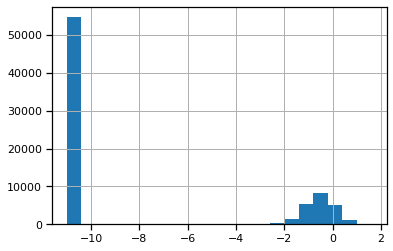

In [105]:
gal['log_sfr'].hist(bins=21)

In [106]:
gal['ssfr'] = gal['log_sfr']-gal['Mstar']
gal['ssfr'].iloc[~nzero] = -12.5

<AxesSubplot:>

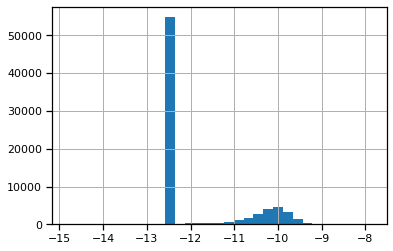

In [107]:
gal['ssfr'].hist(bins=31)

In [108]:
star_forming = (gal['ssfr']>-11.0)
quenching    = np.logical_not(star_forming)

In [109]:
gal['SF'] = np.array(star_forming).astype(int)

# Match Column Names
--------------

In [110]:
mbulge = gal['Mstar_bulge']<8.
gal['Mstar_bulge'].iloc[mbulge] = 8.

/usr/local/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

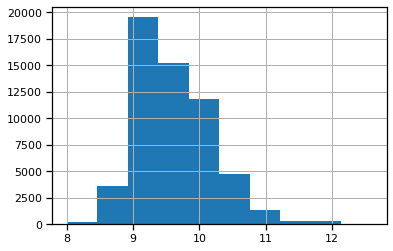

In [111]:
gal['Mstar_bulge'].hist()

In [112]:
gal['R']  = gal['R_proj']
gal['vlos'] = gal['v_los']
gal['mass'] = gal['Mstar']
gal['mass_bulge'] = gal['Mstar_bulge']
gal['BT'] = gal['S_over_T']
gal['age'] = gal['Stellar_age']


In [113]:
gal.columns

Index(['SubhaloID', 'Mstar', 'HostHaloID', 'R_proj', 'v_los', 'V200c_host',
       't_infall', 'Mstar_bulge', 'S_over_T', 'SFR', 'Stellar_age', 'M200',
       'R200', 'Rn', 'vlosn', 't_cross', 'infall', 'orbital', 'interloper',
       'pinfall', 'porbital', 'pinterloper', 'log_sfr', 'ssfr', 'SF', 'R',
       'vlos', 'mass', 'mass_bulge', 'BT', 'age'],
      dtype='object')

In [114]:
columns = ['HostHaloID', 'R', 'vlos', 'mass','mass_bulge', 'BT', 'age', 't_cross', 't_infall', 
           'M200', 'R200', 'Rn', 'vlosn', 'infall', 'orbital', 'interloper', 'pinfall',
           'porbital', 'pinterloper', 'ssfr', 'log_sfr', 'SF']

In [115]:
data = Table.from_pandas(gal[columns])

# Saving File
---------------------------------------


In [116]:
hdf_file[:-5]+'_post.fits'

'../data/TNG300-1_GalEvol_z0p00_post.fits'

In [117]:
fl.gal_fname1 = hdf_file[:-5]+'_post.csv'
data.write(fl.gal_fname1,format='csv',overwrite=True)

In [118]:
data

HostHaloID,R,vlos,mass,mass_bulge,BT,age,t_cross,t_infall,M200,R200,Rn,vlosn,infall,orbital,interloper,pinfall,porbital,pinterloper,ssfr,log_sfr,SF
int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64
0,0.0,175.41616821289062,12.894207,12.59620988942259,0.6683203014229624,11.52411493100761,0.0,--,0.015186332702636718,2.43272216796875,0.0,0.10644230174891758,0,1,0,0.23,0.77,0.0,-12.5,-11.0,0
0,1.9765529616110076,-333.490762578125,12.573412,12.326624271580389,0.7306167093360224,10.778847282851299,5795237315.290921,--,0.015186332702636718,2.43272216796875,0.8124861061554637,-0.20236175913805443,1,1,0,0.38,0.46,0.16,-12.5,-11.0,0
0,0.2375913061413584,1802.144485078125,11.927808,11.720196446196926,0.8096961833053034,11.416510074057875,128910269.40817085,1.473271343778544,0.015186332702636718,2.43272216796875,0.0976647926630027,1.0935389196452479,0,1,0,0.15,0.85,0.0,-12.5,-11.0,0
0,1.2918836592478444,638.5676128125,11.547731,11.357472855810073,0.8031099697294554,10.953497243281014,1978167648.940858,3.5367934314189475,0.015186332702636718,2.43272216796875,0.5310444720148739,0.3874819933792124,0,1,0,0.17,0.36,0.47,-12.5,-11.0,0
0,0.5232071638312963,-498.61809625,11.512753,11.289808954510802,0.7517849975571669,11.176712283854712,1026011488.4887348,0.34682712813420064,0.015186332702636718,2.43272216796875,0.215070660645214,-0.30256080952641135,0,1,0,0.06,0.81,0.13,-12.5,-11.0,0
0,2.7960619778273728,-34.51553913574219,11.130021,10.911074408015745,0.7602802994184678,9.560793847778681,79209762374.72902,--,0.015186332702636718,2.43272216796875,1.1493552427164342,-0.020943984064538828,0,1,0,0.45,0.36,0.19,-12.5,-11.0,0
0,2.296345437501891,-641.7423085742188,11.439258,11.23750189246864,0.7377866944852269,10.928030836020877,3498832283.734865,--,0.015186332702636718,2.43272216796875,0.9439406882288043,-0.38940839462074317,1,1,0,0.53,0.38,0.09,-12.5,-11.0,0
0,2.588531738339998,439.7247854296875,11.189398,10.66223616679104,0.34131283908660387,9.616371177771278,5755978018.941265,--,0.015186332702636718,2.43272216796875,1.0640474166852125,0.2668244254450959,1,0,1,0.41,0.41,0.18,-12.5,-11.0,0
0,2.338867382554795,-1193.2521698828125,10.962668,10.814530818210832,0.9473699670852419,11.155789212933193,1916549068.104912,--,0.015186332702636718,2.43272216796875,0.9614198503019681,-0.724063858099275,1,0,0,0.61,0.2,0.19,-12.5,-11.0,0


In [120]:
data = Table.from_pandas(cat)

In [121]:
fl.gal_fname1 = hdf_file[:-5]+'_cluster_post.csv'
data.write(fl.gal_fname1,format='csv',overwrite=True)